In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display
import librosa.display
import numpy as np
import librosa
import tensorflow as tf
import glob

In [2]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools as it

In [3]:
# Declare Variables
n_mfcc = 16
n_frame = 16
n_classes = 3
n_channels = 1
learning_rate = 0.0002  # 0.005

In [4]:
def run_train(session, train_x, train_y):
    print ("\nStart training")
    session.run(init)
    for epoch in range(100):
        total_batch = int(train_x.shape[0] / batch_size)
        for i in range(total_batch):
            batch_x = train_x[i*batch_size:(i+1)*batch_size]
            batch_y = train_y[i*batch_size:(i+1)*batch_size]
            _, c = session.run([optimizer, cost], feed_dict={X: batch_x, Y: batch_y})
            if i % 100 == 0:
                print ("Epoch #%d step=%d cost=%f" % (epoch, i, c))

In [5]:
def cross_validate(session, split_size=5):
    results = []
    kf = KFold(n_splits=split_size)
    for train_idx, val_idx in kf.split(X_train2, y_train):
        train_x = X_train2[train_idx]
        train_y = y_train[train_idx]
        val_x = X_train2[val_idx]
        val_y = y_train[val_idx]
        run_train(session, train_x, train_y)
        y_true = session.run(tf.argmax(val_y,1))
        y_pred = session.run(tf.argmax(logits,1),feed_dict={X: val_x})
        from sklearn.metrics import accuracy_score
        results.append(accuracy_score(y_true, y_pred))
    return results

In [6]:
### Data Loading ###
X_train = np.load('./X_train_chunk_3d.npy')
X_test = np.load('./X_test_chunk_3d.npy')
y_train = np.load('./y_train_chunk_3d.npy')
y_test = np.load('./y_test_chunk_3d.npy')

# Convolutional Layer

In [7]:
tf.reset_default_graph()

In [8]:
X = tf.placeholder(tf.float32, shape=[None,n_mfcc*n_frame*n_channels])
X = tf.reshape(X, [-1, n_mfcc, n_frame, n_channels])
Y = tf.placeholder(tf.float32, shape=[None,n_classes])

conv1 = tf.layers.conv2d(inputs=X, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2],
                                padding="SAME", strides=1)

conv2 = tf.layers.conv2d(inputs=pool1, filters=1, kernel_size=[3, 3],
                         padding="SAME", activation=tf.nn.relu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2],
                                padding="SAME", strides=1)

flat = tf.reshape(pool2, [-1, 16*16*1])

In [9]:
dense2 = tf.layers.dense(inputs=flat, units=625, activation=tf.nn.relu)
logits = tf.layers.dense(inputs=dense2, units=3)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [10]:
X_train2 = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test2 = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

Y_pred = tf.contrib.layers.fully_connected(logits,n_classes,activation_fn = None)

In [11]:
init = tf.global_variables_initializer()
correct_prediction = tf.equal(tf.argmax(Y_pred, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
### Save Model ###
model_path = './cnnmodel'
saver = tf.train.Saver()

# Run Model

In [13]:
###########################
batch_size = 64
cost_history = np.empty(shape=[1], dtype=float)

with tf.Session() as session:
    result = cross_validate(session)
    print ("Cross-validation result: %s" % result)
    y_true = session.run(tf.argmax(y_train,1))
    y_pred = session.run(tf.argmax(logits,1),feed_dict={X: X_train2})
    from sklearn.metrics import accuracy_score
    print ("Test accuracy: %f" % accuracy_score(y_true, y_pred))
    saver.save(session, model_path)
    y_pred = session.run(tf.argmax(logits,1),feed_dict={X: X_test2})
    y_true = session.run(tf.argmax(y_test,1))


Start training
Epoch #0 step=0 cost=17.031857
Epoch #0 step=100 cost=0.759326
Epoch #0 step=200 cost=0.887678
Epoch #0 step=300 cost=0.698116
Epoch #0 step=400 cost=0.627018
Epoch #1 step=0 cost=0.718163
Epoch #1 step=100 cost=0.594119
Epoch #1 step=200 cost=0.800920
Epoch #1 step=300 cost=0.669151
Epoch #1 step=400 cost=0.633451
Epoch #2 step=0 cost=0.710028
Epoch #2 step=100 cost=0.565258
Epoch #2 step=200 cost=0.734151
Epoch #2 step=300 cost=0.626501
Epoch #2 step=400 cost=0.631410
Epoch #3 step=0 cost=0.689133
Epoch #3 step=100 cost=0.529147
Epoch #3 step=200 cost=0.688971
Epoch #3 step=300 cost=0.589336
Epoch #3 step=400 cost=0.597917
Epoch #4 step=0 cost=0.674298
Epoch #4 step=100 cost=0.495496
Epoch #4 step=200 cost=0.643235
Epoch #4 step=300 cost=0.553674
Epoch #4 step=400 cost=0.550088
Epoch #5 step=0 cost=0.663012
Epoch #5 step=100 cost=0.470275
Epoch #5 step=200 cost=0.613182
Epoch #5 step=300 cost=0.526672
Epoch #5 step=400 cost=0.507226
Epoch #6 step=0 cost=0.653401
Epoch

Epoch #50 step=300 cost=0.187809
Epoch #50 step=400 cost=0.286560
Epoch #51 step=0 cost=0.283898
Epoch #51 step=100 cost=0.268569
Epoch #51 step=200 cost=0.171825
Epoch #51 step=300 cost=0.182837
Epoch #51 step=400 cost=0.284590
Epoch #52 step=0 cost=0.275074
Epoch #52 step=100 cost=0.257215
Epoch #52 step=200 cost=0.168898
Epoch #52 step=300 cost=0.176648
Epoch #52 step=400 cost=0.279068
Epoch #53 step=0 cost=0.268554
Epoch #53 step=100 cost=0.248257
Epoch #53 step=200 cost=0.170977
Epoch #53 step=300 cost=0.178960
Epoch #53 step=400 cost=0.277321
Epoch #54 step=0 cost=0.257814
Epoch #54 step=100 cost=0.246231
Epoch #54 step=200 cost=0.170577
Epoch #54 step=300 cost=0.182423
Epoch #54 step=400 cost=0.269990
Epoch #55 step=0 cost=0.243528
Epoch #55 step=100 cost=0.238194
Epoch #55 step=200 cost=0.173742
Epoch #55 step=300 cost=0.172436
Epoch #55 step=400 cost=0.261129
Epoch #56 step=0 cost=0.233738
Epoch #56 step=100 cost=0.232119
Epoch #56 step=200 cost=0.169325
Epoch #56 step=300 cos

Epoch #0 step=400 cost=0.607949
Epoch #1 step=0 cost=0.536965
Epoch #1 step=100 cost=0.694507
Epoch #1 step=200 cost=0.778893
Epoch #1 step=300 cost=0.607760
Epoch #1 step=400 cost=0.526972
Epoch #2 step=0 cost=0.475060
Epoch #2 step=100 cost=0.600236
Epoch #2 step=200 cost=0.706131
Epoch #2 step=300 cost=0.568049
Epoch #2 step=400 cost=0.480202
Epoch #3 step=0 cost=0.442160
Epoch #3 step=100 cost=0.530965
Epoch #3 step=200 cost=0.655984
Epoch #3 step=300 cost=0.546733
Epoch #3 step=400 cost=0.440723
Epoch #4 step=0 cost=0.414353
Epoch #4 step=100 cost=0.503335
Epoch #4 step=200 cost=0.621921
Epoch #4 step=300 cost=0.529058
Epoch #4 step=400 cost=0.423957
Epoch #5 step=0 cost=0.397075
Epoch #5 step=100 cost=0.477730
Epoch #5 step=200 cost=0.589896
Epoch #5 step=300 cost=0.508807
Epoch #5 step=400 cost=0.404031
Epoch #6 step=0 cost=0.382740
Epoch #6 step=100 cost=0.458312
Epoch #6 step=200 cost=0.571469
Epoch #6 step=300 cost=0.492254
Epoch #6 step=400 cost=0.381510
Epoch #7 step=0 cost

Epoch #51 step=200 cost=0.234446
Epoch #51 step=300 cost=0.163345
Epoch #51 step=400 cost=0.054186
Epoch #52 step=0 cost=0.178989
Epoch #52 step=100 cost=0.216170
Epoch #52 step=200 cost=0.230701
Epoch #52 step=300 cost=0.162127
Epoch #52 step=400 cost=0.049666
Epoch #53 step=0 cost=0.166250
Epoch #53 step=100 cost=0.213717
Epoch #53 step=200 cost=0.217967
Epoch #53 step=300 cost=0.159659
Epoch #53 step=400 cost=0.048133
Epoch #54 step=0 cost=0.163924
Epoch #54 step=100 cost=0.208894
Epoch #54 step=200 cost=0.216998
Epoch #54 step=300 cost=0.164838
Epoch #54 step=400 cost=0.047226
Epoch #55 step=0 cost=0.159337
Epoch #55 step=100 cost=0.207954
Epoch #55 step=200 cost=0.214208
Epoch #55 step=300 cost=0.154038
Epoch #55 step=400 cost=0.044373
Epoch #56 step=0 cost=0.165121
Epoch #56 step=100 cost=0.205906
Epoch #56 step=200 cost=0.216121
Epoch #56 step=300 cost=0.160181
Epoch #56 step=400 cost=0.050879
Epoch #57 step=0 cost=0.149938
Epoch #57 step=100 cost=0.219082
Epoch #57 step=200 cos

Epoch #1 step=400 cost=0.510631
Epoch #2 step=0 cost=0.786777
Epoch #2 step=100 cost=0.698374
Epoch #2 step=200 cost=0.698069
Epoch #2 step=300 cost=0.663545
Epoch #2 step=400 cost=0.489205
Epoch #3 step=0 cost=0.671415
Epoch #3 step=100 cost=0.695791
Epoch #3 step=200 cost=0.760015
Epoch #3 step=300 cost=0.542195
Epoch #3 step=400 cost=0.557626
Epoch #4 step=0 cost=0.644861
Epoch #4 step=100 cost=0.665812
Epoch #4 step=200 cost=0.634824
Epoch #4 step=300 cost=0.505852
Epoch #4 step=400 cost=0.546008
Epoch #5 step=0 cost=0.618119
Epoch #5 step=100 cost=0.601996
Epoch #5 step=200 cost=0.525201
Epoch #5 step=300 cost=0.539477
Epoch #5 step=400 cost=0.509430
Epoch #6 step=0 cost=0.723246
Epoch #6 step=100 cost=0.674178
Epoch #6 step=200 cost=0.507184
Epoch #6 step=300 cost=0.545351
Epoch #6 step=400 cost=0.417270
Epoch #7 step=0 cost=0.643567
Epoch #7 step=100 cost=0.583012
Epoch #7 step=200 cost=0.478914
Epoch #7 step=300 cost=0.526961
Epoch #7 step=400 cost=0.411850
Epoch #8 step=0 cost

Epoch #52 step=200 cost=0.124263
Epoch #52 step=300 cost=0.192845
Epoch #52 step=400 cost=0.139331
Epoch #53 step=0 cost=0.138496
Epoch #53 step=100 cost=0.172643
Epoch #53 step=200 cost=0.118029
Epoch #53 step=300 cost=0.188285
Epoch #53 step=400 cost=0.139030
Epoch #54 step=0 cost=0.140993
Epoch #54 step=100 cost=0.159249
Epoch #54 step=200 cost=0.111128
Epoch #54 step=300 cost=0.177530
Epoch #54 step=400 cost=0.128351
Epoch #55 step=0 cost=0.131599
Epoch #55 step=100 cost=0.155513
Epoch #55 step=200 cost=0.107399
Epoch #55 step=300 cost=0.172998
Epoch #55 step=400 cost=0.122709
Epoch #56 step=0 cost=0.128701
Epoch #56 step=100 cost=0.140481
Epoch #56 step=200 cost=0.109536
Epoch #56 step=300 cost=0.168734
Epoch #56 step=400 cost=0.119778
Epoch #57 step=0 cost=0.119177
Epoch #57 step=100 cost=0.140656
Epoch #57 step=200 cost=0.112200
Epoch #57 step=300 cost=0.164773
Epoch #57 step=400 cost=0.105171
Epoch #58 step=0 cost=0.114158
Epoch #58 step=100 cost=0.127451
Epoch #58 step=200 cos

Epoch #2 step=400 cost=0.460492
Epoch #3 step=0 cost=0.597989
Epoch #3 step=100 cost=0.553009
Epoch #3 step=200 cost=0.626771
Epoch #3 step=300 cost=0.759618
Epoch #3 step=400 cost=0.429592
Epoch #4 step=0 cost=0.574889
Epoch #4 step=100 cost=0.531684
Epoch #4 step=200 cost=0.612559
Epoch #4 step=300 cost=0.729466
Epoch #4 step=400 cost=0.408345
Epoch #5 step=0 cost=0.554269
Epoch #5 step=100 cost=0.510960
Epoch #5 step=200 cost=0.598424
Epoch #5 step=300 cost=0.706407
Epoch #5 step=400 cost=0.391071
Epoch #6 step=0 cost=0.538467
Epoch #6 step=100 cost=0.497517
Epoch #6 step=200 cost=0.585754
Epoch #6 step=300 cost=0.683012
Epoch #6 step=400 cost=0.372213
Epoch #7 step=0 cost=0.525159
Epoch #7 step=100 cost=0.485857
Epoch #7 step=200 cost=0.574171
Epoch #7 step=300 cost=0.661758
Epoch #7 step=400 cost=0.355045
Epoch #8 step=0 cost=0.512958
Epoch #8 step=100 cost=0.474974
Epoch #8 step=200 cost=0.559846
Epoch #8 step=300 cost=0.644161
Epoch #8 step=400 cost=0.339060
Epoch #9 step=0 cost

Epoch #53 step=200 cost=0.080356
Epoch #53 step=300 cost=0.084867
Epoch #53 step=400 cost=0.045622
Epoch #54 step=0 cost=0.095645
Epoch #54 step=100 cost=0.094864
Epoch #54 step=200 cost=0.074647
Epoch #54 step=300 cost=0.078837
Epoch #54 step=400 cost=0.044074
Epoch #55 step=0 cost=0.091560
Epoch #55 step=100 cost=0.091352
Epoch #55 step=200 cost=0.070289
Epoch #55 step=300 cost=0.073523
Epoch #55 step=400 cost=0.038481
Epoch #56 step=0 cost=0.083791
Epoch #56 step=100 cost=0.089105
Epoch #56 step=200 cost=0.065124
Epoch #56 step=300 cost=0.065914
Epoch #56 step=400 cost=0.037661
Epoch #57 step=0 cost=0.079417
Epoch #57 step=100 cost=0.084707
Epoch #57 step=200 cost=0.065375
Epoch #57 step=300 cost=0.066167
Epoch #57 step=400 cost=0.038994
Epoch #58 step=0 cost=0.069421
Epoch #58 step=100 cost=0.080436
Epoch #58 step=200 cost=0.061579
Epoch #58 step=300 cost=0.059471
Epoch #58 step=400 cost=0.041257
Epoch #59 step=0 cost=0.064844
Epoch #59 step=100 cost=0.075859
Epoch #59 step=200 cos

Epoch #3 step=400 cost=0.556868
Epoch #4 step=0 cost=0.408785
Epoch #4 step=100 cost=0.412555
Epoch #4 step=200 cost=0.547782
Epoch #4 step=300 cost=0.764556
Epoch #4 step=400 cost=0.517067
Epoch #5 step=0 cost=0.383051
Epoch #5 step=100 cost=0.390540
Epoch #5 step=200 cost=0.551606
Epoch #5 step=300 cost=0.718954
Epoch #5 step=400 cost=0.473989
Epoch #6 step=0 cost=0.350381
Epoch #6 step=100 cost=0.390063
Epoch #6 step=200 cost=0.550515
Epoch #6 step=300 cost=0.691227
Epoch #6 step=400 cost=0.444477
Epoch #7 step=0 cost=0.339568
Epoch #7 step=100 cost=0.382058
Epoch #7 step=200 cost=0.567647
Epoch #7 step=300 cost=0.639041
Epoch #7 step=400 cost=0.420472
Epoch #8 step=0 cost=0.320819
Epoch #8 step=100 cost=0.369726
Epoch #8 step=200 cost=0.543252
Epoch #8 step=300 cost=0.604748
Epoch #8 step=400 cost=0.395103
Epoch #9 step=0 cost=0.311083
Epoch #9 step=100 cost=0.365591
Epoch #9 step=200 cost=0.521376
Epoch #9 step=300 cost=0.560295
Epoch #9 step=400 cost=0.381117
Epoch #10 step=0 cos

Epoch #54 step=200 cost=0.118473
Epoch #54 step=300 cost=0.196153
Epoch #54 step=400 cost=0.107678
Epoch #55 step=0 cost=0.161026
Epoch #55 step=100 cost=0.111135
Epoch #55 step=200 cost=0.126183
Epoch #55 step=300 cost=0.197707
Epoch #55 step=400 cost=0.091491
Epoch #56 step=0 cost=0.133750
Epoch #56 step=100 cost=0.113524
Epoch #56 step=200 cost=0.118486
Epoch #56 step=300 cost=0.185718
Epoch #56 step=400 cost=0.078588
Epoch #57 step=0 cost=0.133582
Epoch #57 step=100 cost=0.109585
Epoch #57 step=200 cost=0.107945
Epoch #57 step=300 cost=0.185743
Epoch #57 step=400 cost=0.125076
Epoch #58 step=0 cost=0.122297
Epoch #58 step=100 cost=0.111474
Epoch #58 step=200 cost=0.131151
Epoch #58 step=300 cost=0.168976
Epoch #58 step=400 cost=0.073187
Epoch #59 step=0 cost=0.116106
Epoch #59 step=100 cost=0.130766
Epoch #59 step=200 cost=0.101151
Epoch #59 step=300 cost=0.174480
Epoch #59 step=400 cost=0.062747
Epoch #60 step=0 cost=0.094888
Epoch #60 step=100 cost=0.113539
Epoch #60 step=200 cos

# Show  pred result of test set

F-Score: 0.87
Accuracy:  0.8702620496022462
             precision    recall  f1-score   support

          0       0.93      0.92      0.92      3141
          1       0.84      0.87      0.86      2975
          2       0.83      0.81      0.82      2432

avg / total       0.87      0.87      0.87      8548

[[2882  122  137]
 [ 116 2599  260]
 [  94  380 1958]]


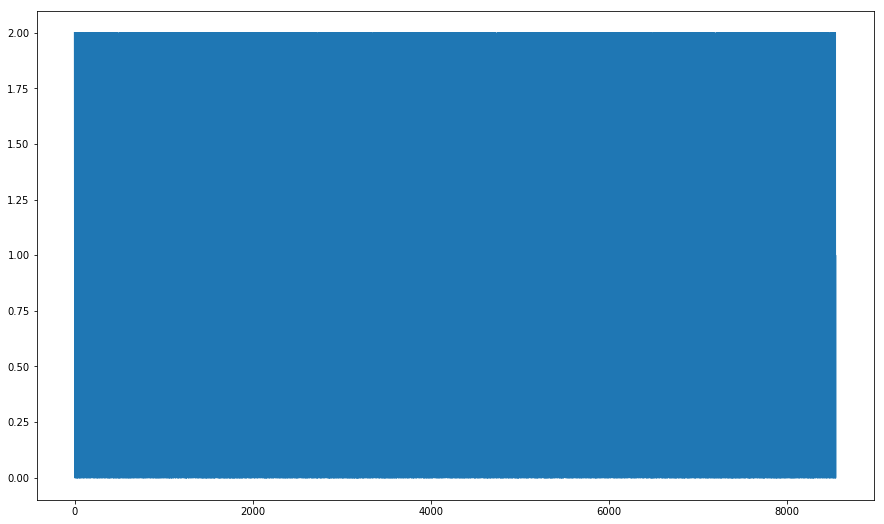

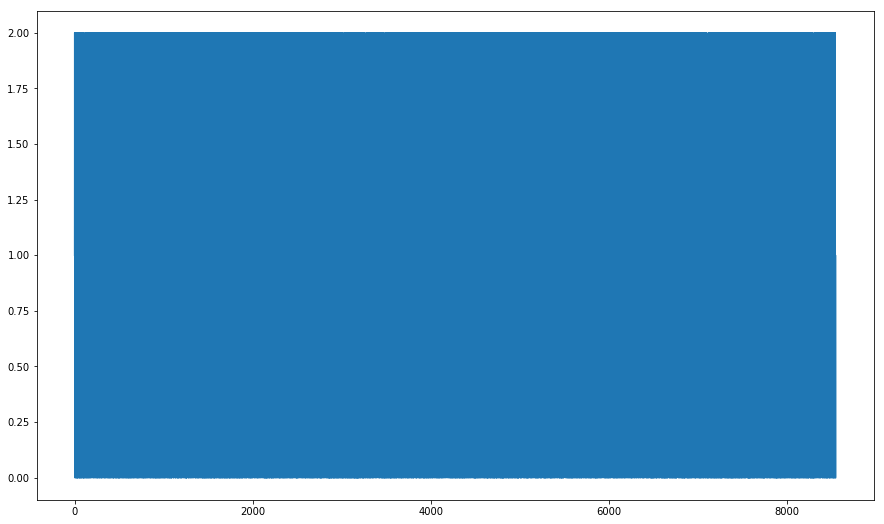

In [14]:
from sklearn.metrics import precision_recall_fscore_support
p,r,f,s = precision_recall_fscore_support(y_true, y_pred, average='micro')
print("F-Score:", round(f,3))
from sklearn.metrics import accuracy_score
print("Accuracy: ", accuracy_score(y_true, y_pred))

### print true graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_true)

### print pred graph###
fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)
ax.plot(np.linspace(0,len(y_pred), len(y_pred)),y_pred)

from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_true, y_pred))